# Calculate metrics

In this notebook metrics are calculated from the features extracted in the ["Extract Features Notebook"](./02_extract_features.ipynb). This notebook loads a dataframe where a lot of municipalities exist with their landingpage html content and metrics calculated on this content (municipality_df). Another dataframe is loaded where the municipalities have additional metrics based on their subpages with depth = 1 (municipality_df_sublinks). This dataframe is much smaller (municipalities n = 84) due to problems in data crawling and the script not running through. 

## Metrics that consider subpages and can be found in municipality_df_sublinks:

### Interactivity
Amount of forms + amount of iFrames over all pages (depth = 1)
### Amount of static content
Amount of PDFs + Word Docs + images over all pages (depth = 1)

## Metrics only with landing page:

### Responsiveness
Amount of Media Queries from CSS

### Connectivity
Amount of links in general + social media links

### Site Performance
Amount of scripts + styles + static content

In [5]:
from sqlalchemy import create_engine
import pandas as pd
import json
from bs4 import BeautifulSoup
import re
import json
import folium
import matplotlib.cm 
import matplotlib.colors as colors
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import branca.colormap as cm
import seaborn as sns
import matplotlib.pyplot as plt

municipality_df = pd.read_csv("../data/municipalities_3_metricized.csv")
engine = create_engine('sqlite:///../data/municipalities.db')
pages_df = pd.read_sql_table('pages', engine)
municipality_df_sublinks = pd.read_csv("../data/municipality_df_sublinks_metricized.csv")
municipality_df_sublinks

id                            name         country  \
0     153                     Nickelsdorf         Austria   
1     856               Kötschach-Mauthen         Austria   
2    1283                    Grieskirchen         Austria   
3    5599  Dobrá Voda u Českých Budějovic  Czech_Republic   
4    5916                         Halámky  Czech_Republic   
..    ...                             ...             ...   
79  84542                       Fuenllana           Spain   
80  85541          Sant Esteve Sesrovires           Spain   
81  85708                     Fontcoberta           Spain   
82  86858                          Cheles           Spain   
83  89416                     ZEYTİNBURNU         Turkiye   

                          email  population        pop_d               status  \
0       gemeinde@nickelsdorf.at      1809.0          NaN             no error   
1   glasfaseranschluss@kelag.at      3321.0          NaN             no error   
2       rathaus@grieskirchen.at      4984.0          NaN             no error   
3         dobra.voda.cb@obce.cz      2675.0  1729.057079  no status available   
4              halamky@quick.cz       194.0    28.136335  no status available   
..                          ...         ...          ...                  ...   
79                          NaN       214.0          NaN       no email found   
80                          NaN      7771.0          NaN       no email found   
81                          NaN      1468.0          NaN       no email found   
82                          NaN      1172.0          NaN       no email found   
83   hdarcan@zeytinburnu.bel.tr    292313.0          NaN  no status available   

                                              content  \
0   <!DOCTYPE html> <html lang="de" dir="ltr" clas...   
1   <!DOCTYPE html><html lang="de-AT" xmlns:og="ht...   
2   \r\n    <!DOCTYPE html>\r\n\r\n\r\n    <html l...   
3   <!DOCTYPE html>\n<html lang="cs">\n<head>\n\t<...   
4   <!DOCTYPE html>\n<html lang="cs" data-lang-sys...   
..                                                ...   
79  <!DOCTYPE html><html lang="es" prefix="og: htt...   
80  <!DOCTYPE HTML>\n<html lang="ca" xmlns="http:/...   
81  <!doctype html>\n<html lang="ca">\n\n<head>\n ...   
82                \n\n\n  \n  \n\n\t\n<!DOCTYPE ht...   
83  <!DOCTYPE html>\n<html lang="tr">\n<head>\n<me...   

                                 url scripts  ... image_count  scripts_count  \
0          http://www.nickelsdorf.at      []  ...        23.0            5.0   
1   http://www.koetschach-mauthen.at      []  ...        23.0            7.0   
2        http://www.grieskirchen.at/      []  ...         7.0           34.0   
3        http://www.dobravodaucb.cz/      []  ...         9.0           22.0   
4           http://www.halamky.info/      []  ...         5.0           12.0   
..                               ...     ...  ...         ...            ...   
79            https://fuenllana.com/      []  ...        22.0           22.0   
80        http://www.sesrovires.cat/      []  ...        32.0           36.0   
81       http://www.fontcoberta.cat/      []  ...         8.0           28.0   
82              http://www.cheles.es      []  ...        36.0           17.0   
83     http://www.zeytinburnu.bel.tr      []  ...        72.0           26.0   

    styles_count   Latitude  Longitude  subpages_forms_count  \
0            3.0  47.940302  17.066176                 143.0   
1            1.0  46.661677  12.971170                   0.0   
2            1.0  48.235011  13.826192                 244.0   
3            0.0  48.968092  14.524649                  91.0   
4            0.0  48.853137  14.915125                   5.0   
..           ...        ...        ...                   ...   
79          10.0  38.755953  -2.958387                  14.0   
80           1.0  41.493243   1.874735                 377.0   
81           7.0  42.142538   2.789782                   2.0   
82           0.

In [6]:
municipality_df_sublinks["forms_total"] = municipality_df_sublinks["forms_count"] + municipality_df_sublinks["subpages_forms_count"]
municipality_df_sublinks["iframes_total"] = municipality_df_sublinks["iframe_count"] + municipality_df_sublinks["subpages_iframes_count"]
municipality_df_sublinks["pdfs_total"] = municipality_df_sublinks["pdf_count"] + municipality_df_sublinks["subpages_pdfs_count"]
municipality_df_sublinks["word_docs_total"] = municipality_df_sublinks["worddoc_count"] + municipality_df_sublinks["subpages_word_docs_count"]
municipality_df_sublinks["images_total"] = municipality_df_sublinks["image_count"] + municipality_df_sublinks["subpages_images_count"]

In [13]:

def cap_outliers(series):
    #q_low = series.quantile(0.0)
    q_high = series.quantile(0.98)
    return series.clip(lower=0, upper=q_high)

def process_feature(feature, df):
    processed_column_name = feature + "_processed"
    series = cap_outliers(df[feature])
    
    robust_scaler = RobustScaler()
    min_max_scaler = MinMaxScaler()

    series = robust_scaler.fit_transform(series.values.reshape(-1, 1))
    series = min_max_scaler.fit_transform(series)

    df[processed_column_name] = series.ravel()

scaler = RobustScaler()
features_from_municipality_df = ["mediaqueries_count", "links_count", "social_media_count", "scripts_count", "styles_count", "pdf_count", "worddoc_count", "image_count"]
for feature in features_from_municipality_df:
    process_feature(feature, municipality_df)

features_from_municipality_df_sublinks = set(["forms_total", "iframes_total", "pdfs_total", "word_docs_total", "images_total"] + features_from_municipality_df)
for feature in features_from_municipality_df_sublinks:
    process_feature(feature, municipality_df_sublinks)

In [15]:
municipality_df["responsiveness"] = (municipality_df["mediaqueries_count_processed"])
municipality_df["connectivity"] = (municipality_df["links_count_processed"] + municipality_df["social_media_count_processed"]) / 2
municipality_df["performance"] = (municipality_df["scripts_count_processed"] + municipality_df["styles_count_processed"] + municipality_df["pdf_count_processed"] + municipality_df["worddoc_count_processed"] + municipality_df["image_count_processed"])/5

municipality_df_sublinks["interactivity"] = (municipality_df_sublinks["forms_total_processed"] + municipality_df_sublinks["iframes_total_processed"]) / 2
municipality_df_sublinks["amount_of_static_content"] = (municipality_df_sublinks["pdfs_total_processed"] + municipality_df_sublinks["word_docs_total_processed"] + municipality_df_sublinks["images_total_processed"])/3
municipality_df_sublinks["responsiveness"] = (municipality_df_sublinks["mediaqueries_count_processed"])
municipality_df_sublinks["connectivity"] = (municipality_df_sublinks["links_count_processed"] + municipality_df_sublinks["social_media_count_processed"]) / 2
municipality_df_sublinks["performance"] = (municipality_df_sublinks["scripts_count_processed"] + municipality_df_sublinks["styles_count_processed"] + municipality_df_sublinks["pdf_count_processed"] + municipality_df_sublinks["worddoc_count_processed"] + municipality_df_sublinks["image_count_processed"])/5

<Axes: ylabel='Frequency'>

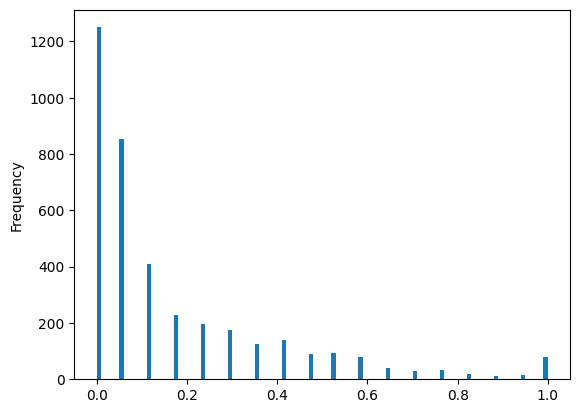

In [16]:
municipality_df.styles_count_processed.plot.hist(bins=100)

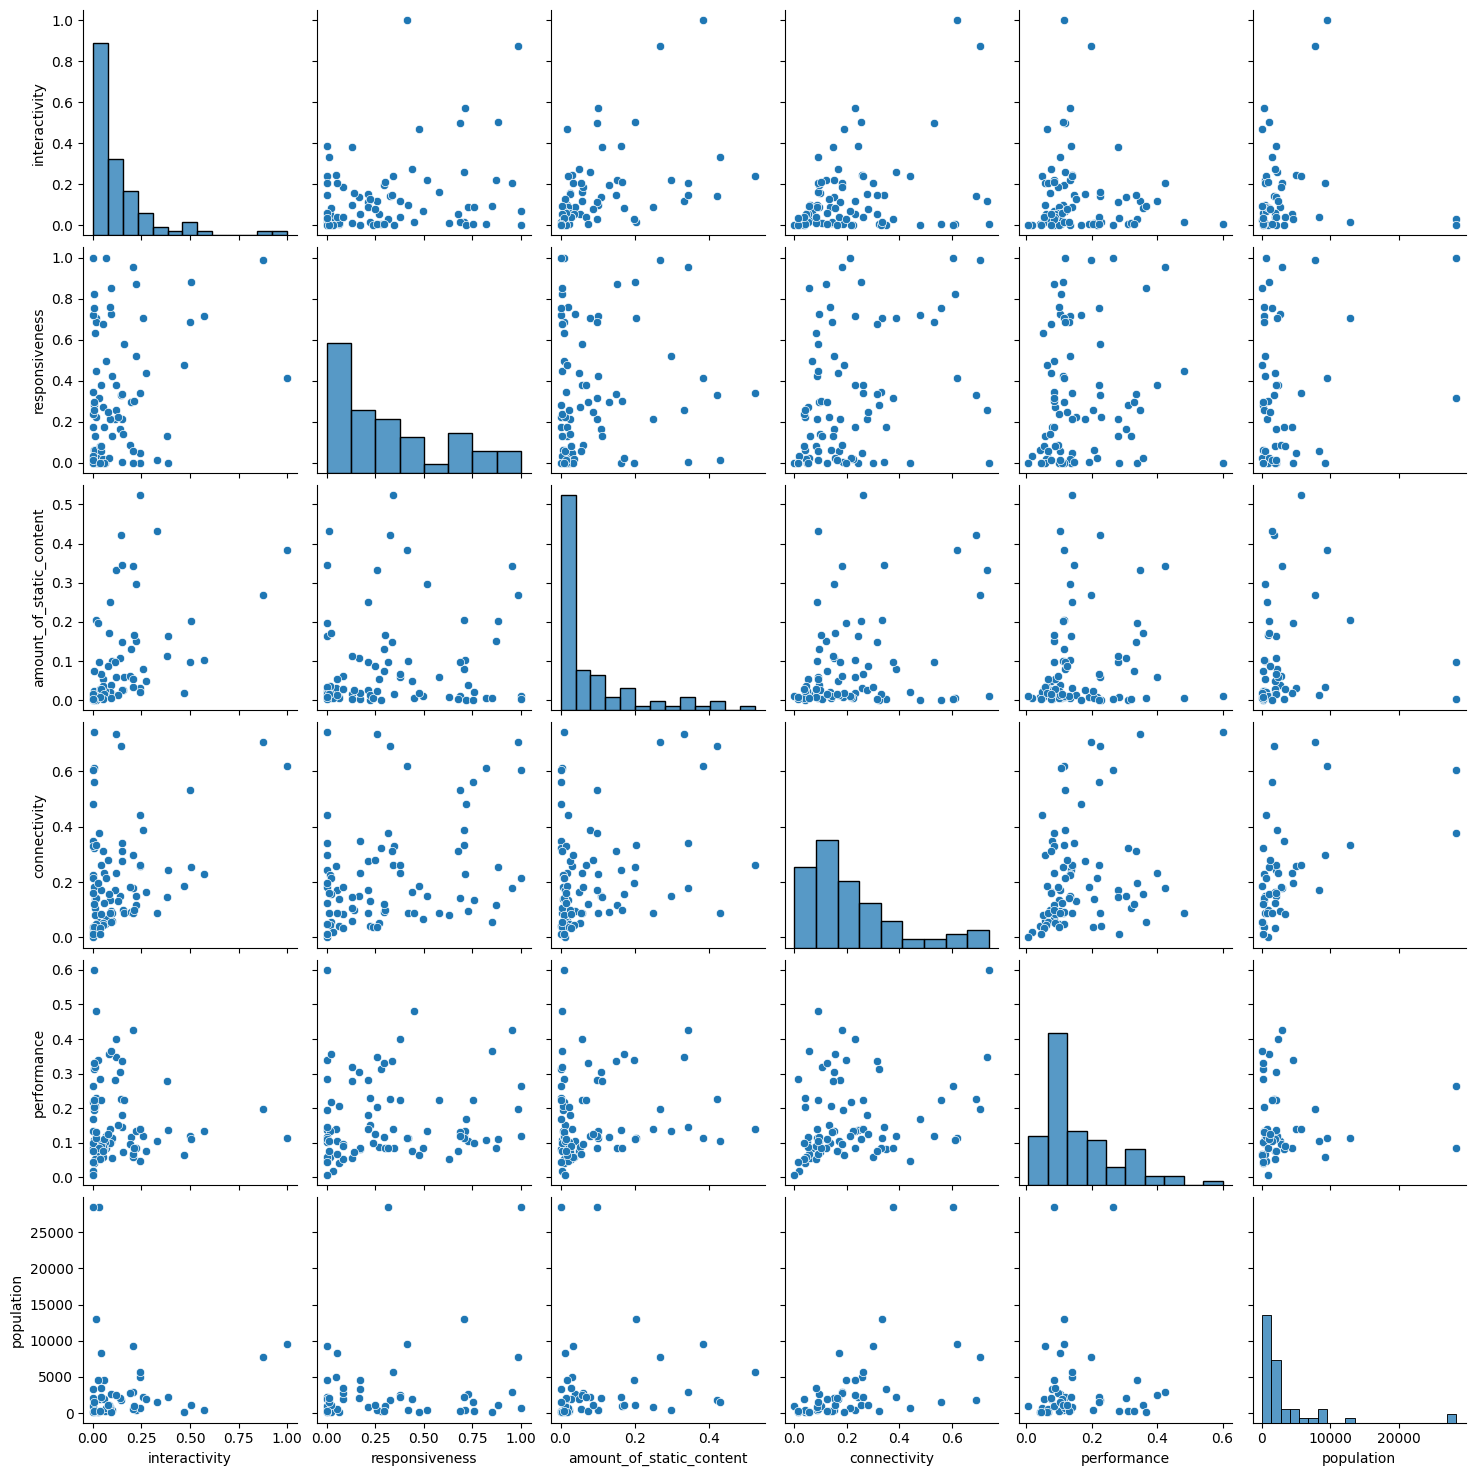

In [19]:
municipality_df_sublinks["population"] = cap_outliers(municipality_df_sublinks["population"])
data = municipality_df_sublinks[["interactivity", "responsiveness", "amount_of_static_content", "connectivity", "performance", "population"]]
sns.pairplot(data)
plt.show()

                          interactivity  responsiveness  \
interactivity                  1.000000        0.271924   
responsiveness                 0.271924        1.000000   
amount_of_static_content       0.503264        0.113408   
connectivity                   0.327529        0.326726   
performance                   -0.087426        0.083695   
population                     0.029968        0.200923   

                          amount_of_static_content  connectivity  performance  \
interactivity                             0.503264      0.327529    -0.087426   
responsiveness                            0.113408      0.326726     0.083695   
amount_of_static_content                  1.000000      0.309166     0.130987   
connectivity                              0.309166      1.000000     0.267718   
performance                               0.130987      0.267718     1.000000   
population                                0.076876      0.488536     0.007771   

                  

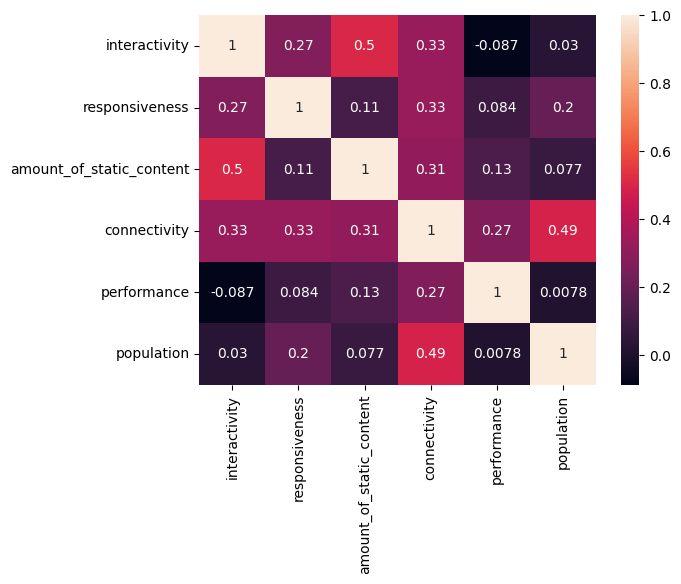

In [20]:
correlation_matrix = data.corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [45]:
municipality_df_sublinks[municipality_df_sublinks.responsiveness == municipality_df_sublinks.responsiveness.min()][["name", "url", "country", "interactivity", "responsiveness", "amount_of_static_content", "connectivity", "performance", "population"]]

name                                            url  \
9            Milín                            http://www.milin.cz   
18          Třebom                          http://www.trebom.cz/   
21          Anduze                   https://www.mairie-anduze.fr   
41  Saint-Grégoire            http://www.mairie-saint-gregoire.fr   
49       Mönkhagen  http://www.amt-nordstormarn.de/?NavID=1137.19   
53       Zorneding                      https://www.zorneding.de/   
62            Dány                             http://www.dany.hu   
64         Őrhalom                              http://orhalom.hu   
67      Cortenuova            http://www.comune.cortenuova.bg.it/   
75         Atajate                         http://www.atajate.net   
79       Fuenllana                         https://fuenllana.com/   

           country  interactivity  responsiveness  amount_of_static_content  \
9   Czech_Republic       0.386322             0.0                  0.163617   
18  Czech_Republic       0.060458             0.0                  0.023276   
21          France       0.005952             0.0                  0.009926   
41          France       0.014881             0.0                  0.008291   
49         Germany       0.242416             0.0                  0.021377   
53         Germany       0.207284             0.0                  0.034891   
62         Hungary       0.028770             0.0                  0.197420   
64         Hungary       0.000000             0.0                  0.011190   
67           Italy       0.058834             0.0                  0.015153   
75           Spain       0.000000             0.0                  0.002082   
79           Spain       0.034320             0.0                  0.008142   

    connectivity  performance  population  
9       0.243082     0.135812      2165.0  
18      0.049520     0.101148       220.0  
21      0.739808     0.600000         NaN  
41      0.050454     0.115773         NaN  
49      0.441006     0.047977       657.0  
53      0.298362     0.059244      9232.0  
62      0.197299     0.338988      4574.0  
64      0.000000     0.006856       925.0  
67      0.124267     0.109935      1927.0  
75      0.014015     0.044383       179.0  
79      0.013081     0.283831       214.0

In [47]:
municipality_df_sublinks[municipality_df_sublinks.responsiveness == municipality_df_sublinks.responsiveness.max()][["name", "url", "country", "interactivity", "responsiveness", "amount_of_static_content", "connectivity", "performance", "population"]]

name                            url  country  interactivity  \
52  Althornbach        http://www.vgzwland.de/  Germany       0.067870   
83  ZEYTİNBURNU  http://www.zeytinburnu.bel.tr  Turkiye       0.000992   

    responsiveness  amount_of_static_content  connectivity  performance  \
52             1.0                  0.010633      0.213183     0.118254   
83             1.0                  0.002045      0.603883     0.265401   

    population  
52      678.00  
83    28455.34

In [158]:
municipality_df_sublinks

id                            name         country  \
10      153                     Nickelsdorf         Austria   
54      856               Kötschach-Mauthen         Austria   
81     1283                    Grieskirchen         Austria   
263    5599  Dobrá Voda u Českých Budějovic  Czech_Republic   
299    5916                         Halámky  Czech_Republic   
...     ...                             ...             ...   
3599  84542                       Fuenllana           Spain   
3635  85541          Sant Esteve Sesrovires           Spain   
3645  85708                     Fontcoberta           Spain   
3697  86858                          Cheles           Spain   
3826  89416                     ZEYTİNBURNU         Turkiye   

                            email population        pop_d  \
10        gemeinde@nickelsdorf.at       1809          NaN   
54    glasfaseranschluss@kelag.at       3321          NaN   
81        rathaus@grieskirchen.at       4984          NaN   
263         dobra.voda.cb@obce.cz       2675  1729.057079   
299              halamky@quick.cz        194    28.136335   
...                           ...        ...          ...   
3599                          NaN        214          NaN   
3635                          NaN       7771          NaN   
3645                          NaN       1468          NaN   
3697                          NaN       1172          NaN   
3826   hdarcan@zeytinburnu.bel.tr     292313          NaN   

                   status                                            content  \
10               no error  <!DOCTYPE html> <html lang="de" dir="ltr" clas...   
54               no error  <!DOCTYPE html><html lang="de-AT" xmlns:og="ht...   
81               no error  \r\n    <!DOCTYPE html>\r\n\r\n\r\n    <html l...   
263   no status available  <!DOCTYPE html>\n<html lang="cs">\n<head>\n\t<...   
299   no status available  <!DOCTYPE html>\n<html lang="cs" data-lang-sys...   
...                   ...                                                ...   
3599       no email found  <!DOCTYPE html><html lang="es" prefix="og: htt...   
3635       no email found  <!DOCTYPE HTML>\n<html lang="ca" xmlns="http:/...   
3645       no email found  <!doctype html>\n<html lang="ca">\n\n<head>\n ...   
3697       no email found                \n\n\n  \n  \n\n\t\n<!DOCTYPE ht...   
3826  no status available  <!DOCTYPE html>\n<html lang="tr">\n<head>\n<me...   

                                   url scripts  ... responsiveness  \
10           http://www.nickelsdorf.at      []  ...       0.328140   
54    http://www.koetschach-mauthen.at      []  ...       0.171737   
81         http://www.grieskirchen.at/      []  ...       0.049068   
263        http://www.dobravodaucb.cz/      []  ...       0.726816   
299           http://www.halamky.info/      []  ...       0.061335   
...                                ...     ...  ...            ...   
3599            https://fuenllana.com/      []  ...       0.000000   
3635        http://www.sesrovires.cat/      []  ...       0.987488   
3645       http://www.fontcoberta.cat/      []  ...       0.754416   
3697              http://www.cheles.es      []  ...       0.248405   
3826     http://www.zeytinburnu.bel.tr      []  ...       1.000000   

      amount_of_static_content  connectivity  styles_count_processed  \
10                    0.422526      0.686091                0.256849   
54                    0.001687      0.337161                0.085616   
81                    0.031265      0.246076                0.085616   
263                   0.038051      0.082943                0.000000   
299                   0.008086      0.028186                0.000000   
...                        ...           ...                     ...   
3599                  0.007900      0.000000                0.856164   
3635                  0.269141      0.699541                0.085616   
3645                  0.000906      0.547399                0.599315 

In [29]:
municipality_df_grouped = municipality_df.groupby("country")["responsiveness"].agg(['mean', 'count']).sort_values(by='mean', ascending=False).where(lambda x: x["count"] > 5).dropna()
municipality_df_grouped

mean  count
country                        
Luxembourg      0.653927    8.0
Belgium         0.459493   41.0
Portugal        0.437582   26.0
Norway          0.390794   23.0
Finland         0.319761   19.0
Netherlands     0.319487   32.0
Slovenia        0.317123   10.0
Spain           0.301476  418.0
Iceland         0.299360    6.0
Turkiye         0.285324   51.0
UK              0.276807   16.0
Slovakia        0.275929   11.0
Italy           0.247972  394.0
Germany         0.229934  722.0
Croatia         0.219541   29.0
Poland          0.204347   93.0
France          0.198191  997.0
Romania         0.179917   44.0
Sweden          0.176895   33.0
Czech_Republic  0.162582  511.0
Austria         0.135742  133.0
Hungary         0.120409  206.0
Bulgaria        0.084849   13.0
Serbia          0.082293    6.0

In [39]:
def plot_map(metric_name, df):
    scaler = MinMaxScaler(feature_range=(0,25))
    scaled_metric_name = "scaled_" + metric_name
    df[scaled_metric_name] = scaler.fit_transform(df[[metric_name]])
    df[scaled_metric_name] += 0.01 # Add 0.01 so that folium knows what to do with 0 values
    color_range = (df[scaled_metric_name].min(), df[scaled_metric_name].max())

    linear = cm.LinearColormap(['red', 'green'], vmin=color_range[0], vmax=color_range[1])

    m = folium.Map(location=[df.iloc[0]['Latitude'], df.iloc[0]['Longitude']], zoom_start=5)

    def make_popup_content(row):
        return '''
        <p>{}</p>
        <p>{}</p>
        <p>{}: {}</p>
        '''.format(row["name"], row["country"], metric_name, str(100*row[metric_name]) + "%")

    for i, row in df.iterrows():
        metric = row[scaled_metric_name]
        radius = metric if metric < 25 else 25
        popup = folium.Popup(html=make_popup_content(row), max_width=300)
        folium.CircleMarker(location=(row["Latitude"], row["Longitude"]), 
                            radius=metric,
                            popup=popup,
                            color=linear(metric), 
                            fill_color=linear(metric), 
                            fill_opacity=0.2,
                            fill=True
                    ).add_to(m)

    # Display the map


    size_legend_html = '''
    <div style="position: fixed; 
                 top: 50px; 
                 right: 50px; 
                 width: 280px; 
                 height: 60px; 
                 border: 2px solid grey; 
                 z-index: 9999;
                 font-size: 20px;
                 background-color:white;
                 ">
      &nbsp;<b>Size Legend</b><br>
      &nbsp; Big and Green = High Score<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(size_legend_html))


    return m

#"interactivity", "responsiveness", "amount_of_static_content", "connectivity", "performance", "population"
# municipality_df has more data but no sublinks data. Use for metrics without subpage such as responsiveness, connectivity and performance
# municipality_df_sublinks has less data but has sublinks data. Use for metrics with subpage such as interactivity and amount_of_static_content
m = plot_map("responsiveness", municipality_df)
m.save("../data/vis/responsiveness.html")
m